# Per-Sample vs Global Permutation on IY010 Datasets

Claim: A Transformer can learn under a fixed (global) permutation of time steps (it’s just a relabeling). To truly invalidate sequence order, you must randomize the permutation per sample — and keep the pipeline hardened against leakage. This notebook mirrors the analysis in `transformer_simulation_7_varying_1_stat_analysis.ipynb` but evaluates Original vs Global vs Per‑sample permutations.

In [4]:
from __future__ import annotations
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pathlib import Path
import sys, os

# Add src to Python path (same relative layout as the other notebook)
sys.path.append(str(Path.cwd().parent.parent.parent / 'src'))

from classifiers.svm_classifier import svm_classifier
from classifiers.lstm_classifier import lstm_classifier
from classifiers.transformer_classifier import transformer_classifier
from utils.data_processing import add_binary_labels
from utils.standardise_time_series import standardise_time_series
from utils.shuffle_time_series import shuffle_time_series
from utils.load_data import load_and_split_data

BASE_DIR = Path.cwd().parent  # experiments/EXP-25-IY010
OUT_DIR = BASE_DIR
RANDOM_STATE = 42
print('BASE_DIR:', BASE_DIR)


BASE_DIR: /home/ianyang/stochastic_simulations/experiments/EXP-25-IY010


## Helpers

In [5]:
def prepare_labelled_data(synthetic_dir: Path, results_csv: Path, label_column: str):
    results = pd.read_csv(results_csv)
    # Mirror original filters
    results = results[results['success']].dropna(subset=['mu_observed','cv_observed','t_ac_observed'])
    labelled_results = add_binary_labels(results, label_column)

    # Load trajectories and standardize length
    data_frames, labels = [], []
    for i in range(len(results)):
        trajectory_filename = results['trajectory_filename'].values[i]
        data = pd.read_csv(synthetic_dir / trajectory_filename)
        data_frames.append(data)
        label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
        labels.append(label_value)
    labelled_data = standardise_time_series(data_frames, labels=labels, prefix='t_')
    return labelled_data

def evaluate_all(df: pd.DataFrame, temp_prefix: str, *, seed: int = 42):
    # Save original to temp for consistent splitting
    temp_path = BASE_DIR / f'{temp_prefix}_orig.csv'
    df.to_csv(temp_path, index=False)
    X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(temp_path, split_val_size=0.2)

    print('SVM (Original)')
    svm_acc = svm_classifier(X_train, X_test, y_train, y_test, svm_C=1.0, svm_gamma='scale', svm_kernel='rbf')
    print('LSTM (Original)')
    lstm_acc = lstm_classifier(X_train, X_val, X_test, y_train, y_val, y_test, epochs=100, hidden_size=128, num_layers=4, dropout_rate=0.2, learning_rate=0.001, batch_size=64, use_conv1d=True, use_attention=True, num_attention_heads=4)
    print('Transformer (Original)')
    transformer_acc = transformer_classifier(X_train, X_val, X_test, y_train, y_val, y_test, d_model=128, nhead=8, num_layers=4, epochs=50, use_conv1d=True, use_auxiliary=True)

    # Global permutation: same column permutation for all rows
    df_global = shuffle_time_series(df, preserve_columns=['label'], random_state=seed, strategy='global')
    temp_global = BASE_DIR / f'{temp_prefix}_global.csv'
    df_global.to_csv(temp_global, index=False)
    X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g = load_and_split_data(temp_global, split_val_size=0.2)
    print('SVM (Global perm)')
    svm_acc_g = svm_classifier(X_train_g, X_test_g, y_train_g, y_test_g, svm_C=1.0, svm_gamma='scale', svm_kernel='rbf')
    print('LSTM (Global perm)')
    lstm_acc_g = lstm_classifier(X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g, epochs=100, hidden_size=128, num_layers=4, dropout_rate=0.2, learning_rate=0.001, batch_size=64, use_conv1d=True, use_attention=True, num_attention_heads=4)
    print('Transformer (Global perm)')
    transformer_acc_g = transformer_classifier(X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g, d_model=128, nhead=8, num_layers=4, epochs=50, use_conv1d=True, use_auxiliary=True)

    # Per-sample permutation: break order within each row independently
    df_ps = shuffle_time_series(df, preserve_columns=['label'], random_state=seed+1, strategy='per_sample')
    temp_ps = BASE_DIR / f'{temp_prefix}_per_sample.csv'
    df_ps.to_csv(temp_ps, index=False)
    X_train_ps, X_val_ps, X_test_ps, y_train_ps, y_val_ps, y_test_ps = load_and_split_data(temp_ps, split_val_size=0.2)
    print('SVM (Per-sample perm)')
    svm_acc_ps = svm_classifier(X_train_ps, X_test_ps, y_train_ps, y_test_ps, svm_C=1.0, svm_gamma='scale', svm_kernel='rbf')
    print('LSTM (Per-sample perm)')
    lstm_acc_ps = lstm_classifier(X_train_ps, X_val_ps, X_test_ps, y_train_ps, y_val_ps, y_test_ps, epochs=100, hidden_size=128, num_layers=4, dropout_rate=0.2, learning_rate=0.001, batch_size=64, use_conv1d=True, use_attention=True, num_attention_heads=4)
    print('Transformer (Per-sample perm)')
    transformer_acc_ps = transformer_classifier(X_train_ps, X_val_ps, X_test_ps, y_train_ps, y_val_ps, y_test_ps, d_model=128, nhead=8, num_layers=4, epochs=50, use_conv1d=True, use_auxiliary=True)

    # Clean temp files
    for p in (temp_path, temp_global, temp_ps):
        try:
            os.remove(p)
        except Exception:
            pass

    return {
        'svm_original': svm_acc, 'svm_global': svm_acc_g, 'svm_per_sample': svm_acc_ps,
        'lstm_original': lstm_acc, 'lstm_global': lstm_acc_g, 'lstm_per_sample': lstm_acc_ps,
        'transformer_original': transformer_acc, 'transformer_global': transformer_acc_g, 'transformer_per_sample': transformer_acc_ps,
    }


## Run the three dataset variants

In [8]:
results = {'parameter': [],
           'svm_original': [], 'svm_global': [], 'svm_per_sample': [],
           'lstm_original': [], 'lstm_global': [], 'lstm_per_sample': [],
           'transformer_original': [], 'transformer_global': [], 'transformer_per_sample': []}

# 1) Vary Autocorrelation Time (t_ac_target)
print('=== Dataset: Vary t_ac_target (mu, cv fixed) ===')
SYNTHETIC_DIR = BASE_DIR / 'data_7_mu_cv_fixed'
RESULTS_CSV = BASE_DIR / 'IY010_simulation_parameters_7_mu_cv_fixed.csv'
df_tac = prepare_labelled_data(SYNTHETIC_DIR, RESULTS_CSV, label_column='t_ac_target')
res_tac = evaluate_all(df_tac, temp_prefix='t_ac_target', seed=RANDOM_STATE)
results['parameter'].append('Autocorrelation Time')
for k in res_tac: results[k].append(res_tac[k])

# 2) Vary CV (cv_target)
print('=== Dataset: Vary cv_target (mu, t_ac fixed) ===')
SYNTHETIC_DIR = BASE_DIR / 'data_7_mu_t_ac_fixed'
RESULTS_CSV = BASE_DIR / 'IY010_simulation_parameters_7_mu_t_ac_fixed.csv'
df_cv = prepare_labelled_data(SYNTHETIC_DIR, RESULTS_CSV, label_column='cv_target')
res_cv = evaluate_all(df_cv, temp_prefix='cv_target', seed=RANDOM_STATE)
results['parameter'].append('CV')
for k in res_cv: results[k].append(res_cv[k])

# 3) Vary Mean (mu_target)
print('=== Dataset: Vary mu_target (cv, t_ac fixed) ===')
SYNTHETIC_DIR = BASE_DIR / 'data_7_cv_t_ac_fixed'
RESULTS_CSV = BASE_DIR / 'IY010_simulation_parameters_7_cv_t_ac_fixed.csv'
df_mu = prepare_labelled_data(SYNTHETIC_DIR, RESULTS_CSV, label_column='mu_target')
res_mu = evaluate_all(df_mu, temp_prefix='mu_target', seed=RANDOM_STATE)
results['parameter'].append('Mean')
for k in res_mu: results[k].append(res_mu[k])

results_df = pd.DataFrame(results)
results_df


=== Dataset: Vary t_ac_target (mu, cv fixed) ===
SVM (Original)
=== SVM (RBF Kernel) Classification Accuracy: 0.83 ===
LSTM (Original)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===
Transformer (Original)
=== Transformer with Conv1D and Auxiliary Task Accuracy: 1.00 ===
SVM (Global perm)
=== SVM (RBF Kernel) Classification Accuracy: 0.83 ===
LSTM (Global perm)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===
Transformer (Global perm)
=== Transformer with Conv1D and Auxiliary Task Accuracy: 1.00 ===
SVM (Per-sample perm)
=== SVM (RBF Kernel) Classification Accuracy: 0.71 ===
LSTM (Per-sample perm)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===
Transformer (Per-sample perm)
=== Transformer with Conv1D and Auxiliary Task Accuracy: 1.00 ===
=== Dataset: Vary cv_target (mu, t_ac fixed) ===
SVM (Original)
=== SVM (RBF Kernel) Classification Accuracy: 0.92 ===
LSTM (Original)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===
Transformer (Orig

,parameter,svm_original,svm_global,svm_per_sample,lstm_original,lstm_global,lstm_per_sample,transformer_original,transformer_global,transformer_per_sample
0,Autocorrelation Time,0.828723,0.829787,0.705319,1.0,1.00000,1.0,1.0,1.0,1.0
1,CV,0.924479,0.925521,0.916146,1.0,1.00000,1.0,1.0,1.0,1.0
2,Mean,0.890000,0.888750,0.862500,1.0,0.99875,1.0,1.0,1.0,1.0


## Plot: Original vs Global vs Per-sample

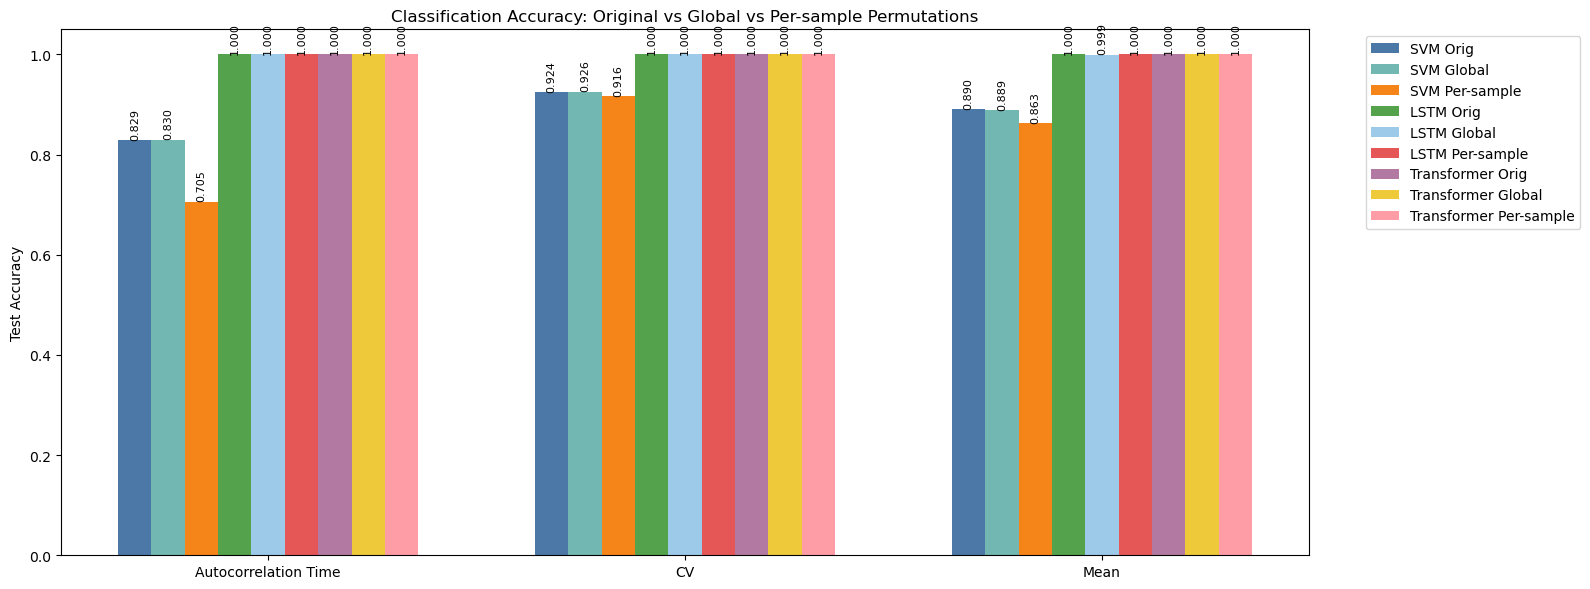

In [9]:
import numpy as np
labels = results_df['parameter'].tolist()
x = np.arange(len(labels))
width = 0.08
fig, ax = plt.subplots(figsize=(16,6))
series = [
    ('SVM Orig', results_df['svm_original'].values),
    ('SVM Global', results_df['svm_global'].values),
    ('SVM Per-sample', results_df['svm_per_sample'].values),
    ('LSTM Orig', results_df['lstm_original'].values),
    ('LSTM Global', results_df['lstm_global'].values),
    ('LSTM Per-sample', results_df['lstm_per_sample'].values),
    ('Transformer Orig', results_df['transformer_original'].values),
    ('Transformer Global', results_df['transformer_global'].values),
    ('Transformer Per-sample', results_df['transformer_per_sample'].values),
]
colors = ['#4c78a8','#72b7b2','#f58518', '#54a24b','#9ecae9','#e45756', '#b279a2','#eeca3b','#ff9da7']
for i,(name,vals) in enumerate(series):
    ax.bar(x + (i-4)*width, vals, width, label=name, color=colors[i%len(colors)])
    for j,v in enumerate(vals):
        ax.text(x[j] + (i-4)*width, v+0.005, f'{v:.3f}', ha='center', fontsize=8, rotation=90)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Test Accuracy')
ax.set_title('Classification Accuracy: Original vs Global vs Per-sample Permutations')
ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.tight_layout()
plt.show()


## Leakage hardening
- Use `shuffle_time_series(..., strategy='global')` for an order-control that should not affect SVM/MLP models.
- Use `strategy='per_sample'` to truly break order; apply independently to train/val/test (this notebook does so by shuffling the entire DataFrame and then splitting).
- No labels are used for permutations.
- Classifier wrappers fit scalers only on training data.
- Splitting is stratified to preserve class balance.
- Temporary CSVs are deleted after each run to avoid stale data.